In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.layers import Input,Dense,Reshape,Conv2D,Dropout,multiply,dot
from keras.layers import BatchNormalization,LeakyReLU,Flatten,Embedding
from keras.layers import Conv2DTranspose as Deconv2d
from keras.models import Sequential, Model
from keras.optimizers import Adam

from keras import backend as K


from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
import mnist_reader

X_whole, Y_whole = mnist_reader.load_mnist('', kind='train')

In [3]:

i_A = np.argwhere(Y_whole==0)
i_B = np.argwhere(Y_whole==1)

x_a = X_whole[i_A].reshape(6000,28,28,1)/255
x_b = X_whole[i_B].reshape(6000,28,28,1)/255

x_shape = (28,28,1)


In [4]:
def plot(A,AB,ABA,n):

    samples = [A,AB,ABA]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(3):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(samples[i][j].reshape(28, 28), cmap='Greys_r')

    return fig

In [5]:
def discriminator():
    
    model = Sequential()
    
    model.add(Conv2D(4,kernel_size = 3, strides = 2,input_shape = x_shape))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(8,kernel_size = 3))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(16,kernel_size = 3))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(32,kernel_size = 3))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(1,activation = 'sigmoid'))
    
    return model

In [6]:
def generator():
  
    model = Sequential()
    
    model.add(Conv2D(4,kernel_size = 3, strides = 2,input_shape = x_shape))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(8,kernel_size = 3))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(16,kernel_size = 3))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Flatten())
    model.add(Dense(512))
    
    model.add(Dense(9*9*16))
    model.add(Reshape((9,9,16)))
    model.add(Deconv2d(8,kernel_size = 3,activation = "relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Deconv2d(4,kernel_size = 3,activation = "relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Deconv2d(1,kernel_size = 4,activation = "tanh",strides = 2))
    
    return model

In [7]:
genAB = generator()
genBA = generator()

disA = discriminator()
disB = discriminator()

X_A = Input(shape = x_shape)
X_AB = genAB(X_A)
X_ABA = genBA(X_AB)

X_A_Flatten = Flatten()(X_A)
X_ABA_Flatten = Flatten()(X_ABA)

D_X_AB = disB(X_AB)

cosdist_X_A = dot([X_A_Flatten,X_ABA_Flatten], normalize = True,axes=1)

combined_AB = Model(X_A,[D_X_AB,cosdist_X_A])

X_B = Input(shape = x_shape)
X_BA = genBA(X_B)
X_BAB = genAB(X_BA)

X_B_Flatten = Flatten()(X_B)
X_BAB_Flatten = Flatten()(X_BAB)

D_X_BA = disA(X_BA)

cosdist_X_B = dot([X_B_Flatten,X_BAB_Flatten], normalize = True,axes=1)

combined_BA = Model(X_B,[D_X_BA,cosdist_X_B])

In [8]:
adams = Adam(lr = 0.0001)
combined_AB.compile(loss=['binary_crossentropy','binary_crossentropy'],optimizer = adams)
combined_BA.compile(loss=['binary_crossentropy','binary_crossentropy'],optimizer = adams)
disA.compile(loss='binary_crossentropy',optimizer = adams)
disB.compile(loss='binary_crossentropy',optimizer = adams)

In [9]:
epochs = 20
batch_size = 16
batches = int(6000/16)
dis_updates = 1
gen_updates = 1
zero=np.zeros((batch_size,1))
one=np.ones((batch_size,1))
d_loss_factor = batches*2*dis_updates
g_loss_factor = batches*gen_updates

In [10]:
if(True):

    genAB.load_weights("generatorAB_n.h5")
    genBA.load_weights("generatorBA_n.h5")
    disA.load_weights("discriminatorA_n.h5")
    disB.load_weights("discriminatorB_n.h5")

In [ ]:

for epoch in range(epochs):
    
    print("##############")
    print("For Epoch:"+str(epoch))
    
    dA_loss = 0
    dB_loss = 0
    
    gAB_loss = 0
    gABA_loss = 0
    gBA_loss = 0
    gBAB_loss = 0
    
    print("Training Discriminator")
    
    i_a = shuffle(range(6000))
    i_b = shuffle(range(6000))
    
    disA.trainable = True
    disB.trainable = True
        
    disA.compile(loss = "binary_crossentropy", optimizer = adams)
    disB.compile(loss = "binary_crossentropy", optimizer = adams)
    
    for j in range(dis_updates):
      
      for b in range(batches):
        
        x_a_batch = x_a[i_a[b*batch_size:(b+1)*batch_size]]
        x_b_batch = x_b[i_b[b*batch_size:(b+1)*batch_size]]
        
        x_ab_batch = genAB.predict(x_a_batch)
        x_ba_batch = genBA.predict(x_b_batch)
        
        dA_loss += disA.train_on_batch(x_a_batch,one)
        dA_loss += disA.train_on_batch(x_ba_batch,zero)
        
        dB_loss += disB.train_on_batch(x_b_batch,one)
        dB_loss += disB.train_on_batch(x_ab_batch,zero)
    
    print("Training Generator") 
    
    disA.trainable = False
    disB.trainable = False
        
    disA.compile(loss = "binary_crossentropy", optimizer = adams)
    disB.compile(loss = "binary_crossentropy", optimizer = adams)
    combined_AB.compile(loss=['binary_crossentropy','binary_crossentropy'],optimizer = adams)
    combined_BA.compile(loss=['binary_crossentropy','binary_crossentropy'],optimizer = adams)
    
    
    for j in range(gen_updates):
      
      for b in range(batches):
        
        x_a_batch = x_a[i_a[b*batch_size:(b+1)*batch_size]]
        x_b_batch = x_b[i_b[b*batch_size:(b+1)*batch_size]]
                
        _,lab,laba = combined_AB.train_on_batch(x_a_batch,[one,one])
        _,lba,lbab = combined_BA.train_on_batch(x_b_batch,[one,one])  
            
        gAB_loss += lab
        gABA_loss += laba
        gBA_loss += lba
        gBAB_loss += lbab
    
    dA_loss /= d_loss_factor
    dB_loss /= d_loss_factor
    
    gAB_loss /= g_loss_factor
    gABA_loss /= g_loss_factor
    gBA_loss /= g_loss_factor
    gBAB_loss /= g_loss_factor
    
    if epoch%3==2:
    
        print("DisA loss:"+str(dA_loss))
        print("DisB loss:"+str(dB_loss))    
        print("GenAB loss:"+str(gAB_loss))
        print("GenABA loss:"+str(gABA_loss))    
        print("GenBA loss:"+str(gBA_loss))
        print("GenBAB loss:"+str(gBAB_loss))
        
        #plt_indices = np.random.randint(1000,size=3) 
        #plt_x_a = x_a[plt_indices]
        #plt_x_ab = genAB.predict(plt_x_a)
        #plt_x_aba = genBA.predict(plt_x_ab)
        #plt_x_b = x_b[plt_indices]
        #plt_x_ba = genBA.predict(plt_x_b)
        #plt_x_bab = genAB.predict(plt_x_ba)
        #fig = plot(plt_x_a,plt_x_ab,plt_x_aba,3)
        #fig = plot(plt_x_b,plt_x_ba,plt_x_bab,3)
        #plt.show()
        #plt.close(fig) 
        
        genAB.save_weights("generatorAB_n.h5")
        genBA.save_weights("generatorBA_n.h5")
        disA.save_weights("discriminatorA_n.h5")
        disB.save_weights("discriminatorB_n.h5")
      

##############
For Epoch:0
Training Discriminator
Training Generator
##############
For Epoch:1
Training Discriminator
Training Generator
##############
For Epoch:2
Training Discriminator
Training Generator
DisA loss:0.046627135484392054
DisB loss:0.05768821697197078
GenAB loss:0.06144740722638865
GenABA loss:0.05489670750002066
GenBA loss:0.10375010728614871
GenBAB loss:0.027102981413404146
##############
For Epoch:3
Training Discriminator
Training Generator
##############
For Epoch:4
Training Discriminator
Training Generator
##############
For Epoch:5
Training Discriminator
Training Generator
DisA loss:0.03845943924008558
DisB loss:0.035424724905741944
GenAB loss:0.05745373509490552
GenABA loss:0.05467818689843019
GenBA loss:0.11526924025678696
GenBAB loss:0.025846634097397327
##############
For Epoch:6
Training Discriminator
Training Generator
##############
For Epoch:7
Training Discriminator
Training Generator
##############
For Epoch:8
Training Discriminator
Training Generator
Dis

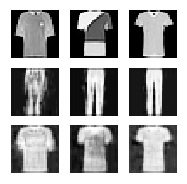

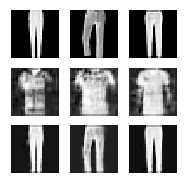

In [59]:
plt_indices = np.random.randint(1000,size=3) 
plt_x_a = x_a[plt_indices]
plt_x_ab = genAB.predict(plt_x_a)
plt_x_aba = genBA.predict(plt_x_ab)
plt_x_b = x_b[plt_indices]
plt_x_ba = genBA.predict(plt_x_b)
plt_x_bab = genAB.predict(plt_x_ba)
fig = plot(plt_x_a,plt_x_ab,plt_x_aba,3)
fig = plot(plt_x_b,plt_x_ba,plt_x_bab,3)
plt.show()
plt.close(fig) 